In [153]:
import numpy as np
import math
from scipy import ndimage, signal
from skimage import io, morphology, filters, segmentation, measure, color
from matplotlib import pyplot as plt, patches
%matplotlib inline

# Test Instance
Cargar una imagen para su exploración inicial.

In [2]:
imageFilename = "./test-images/rut_1.png"

In [3]:
image=io.imread(imageFilename)

## Original Image

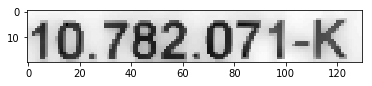

In [4]:
plt.imshow(image,cmap='gray')
plt.show()

## Apply Threshold

Se aplica la función umbral para separar con claridad los dígitos del fondo.

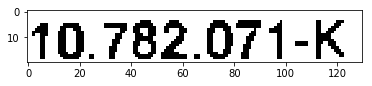

In [5]:
th=filters.threshold_otsu(image*0.95)
im_bin = image > th
plt.imshow(im_bin, cmap='gray')
plt.show()

## Get image labels and regions

El método labels busca zonas continuas, con conectividad configurable, en este caso 1, para buscar zonas conexas.

In [6]:
mlabels, nlabels = morphology.label(1-im_bin, connectivity=1, return_num=True)
regions = measure.regionprops(mlabels)

## Draw rectangles around regions
Identificar con un rectángulo cada una de las zonas encontradas.

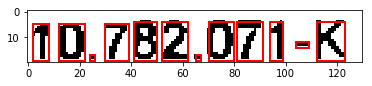

In [7]:
fig, ax = plt.subplots()
ax.imshow(im_bin,cmap='gray')

for i in range(nlabels):
    x, y, w, h = regions[i].bbox
    rect = patches.Rectangle((y, x), h - y, w - x,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
plt.show()

## Calculate region Area
Función auxiliar para el cálculo del área de cada región. Se utilizará posteriormente para filtrar los puntos y guiones.

In [21]:
def getSliceTupleArea(sliceTuple):
    return (sliceTuple[0].stop - sliceTuple[0].start) * (sliceTuple[1].stop - sliceTuple[1].start)

## Inspect region areas

Prueba del cálculo de áreas. Se pueden apreciar algunas zonas de 4 pixeles, correspondientes a los puntos; y una de 10, correspondiente al guión.

In [34]:
roiList = []
for i in range(1, nlabels + 1):
    px, py = ndimage.find_objects(mlabels==i)[0]
    roiList.append((px,py))
    
sortedRoi = sorted(roiList, key= lambda x: x[1])

for i in range(len(sortedRoi)):
    print("region", i, "=", getSliceTupleArea(sortedRoi[i]))


region 0 = 84
region 1 = 140
region 2 = 4
region 3 = 126
region 4 = 135
region 5 = 150
region 6 = 4
region 7 = 150
region 8 = 150
region 9 = 75
region 10 = 10
region 11 = 165


## Ploting individually
Al plotear individualmente cada zona, se puede apreciar que el órden no queda según sus coordenadas, sino según sus coordenada en Y, empezando desde arriba. Será necesario reordenar las imágenes para que queden según su orden natural.

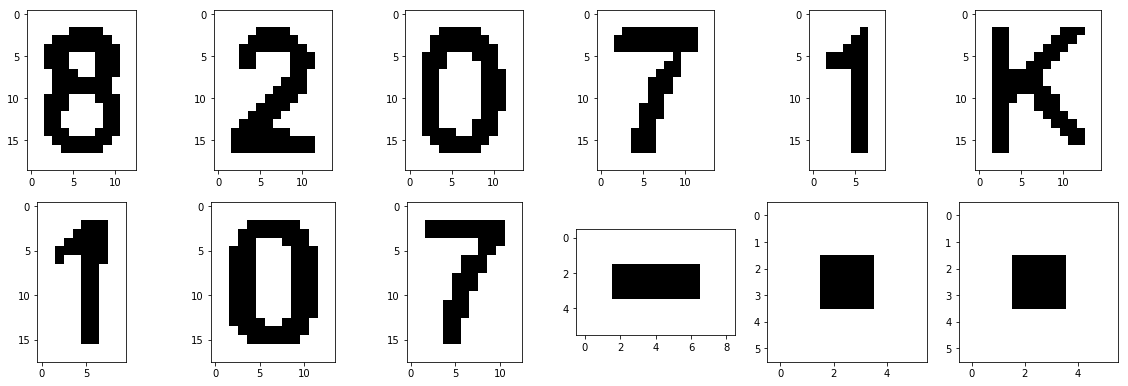

In [11]:
plt.figure(figsize=(20,10))
columns = 6
for i in range(1, nlabels + 1):
    px, py = ndimage.find_objects(mlabels==i)[0]
    roi = im_bin[px, py]
    roi = np.pad(roi, 2, mode='constant', constant_values=1)
    plt.subplot(nlabels / columns + 1, columns, i)
    plt.imshow(roi, cmap="gray")

## Sorting

Se ordenan según la coordenada de la imagen original.

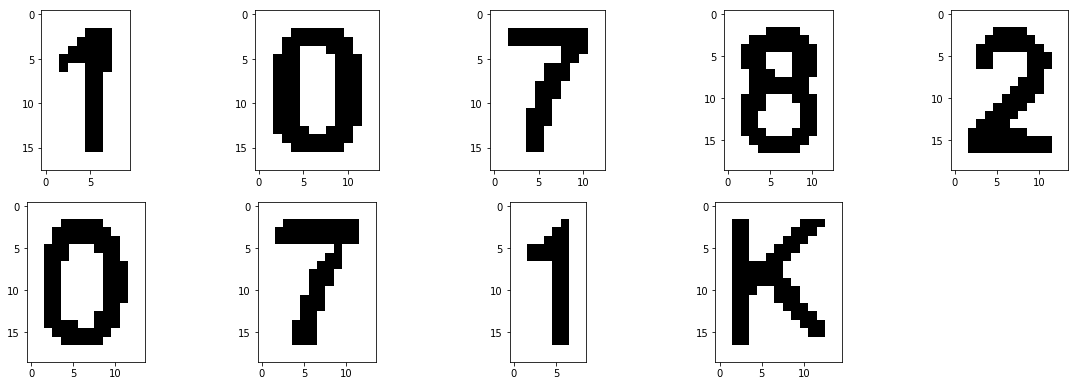

In [31]:
plt.figure(figsize=(20,10))
columns = 5
i = 0
for j in range(nlabels):
    (px, py) = sortedRoi[j]
    if(getSliceTupleArea((px,py))>10):
        roi = im_bin[px, py]
        roi = np.pad(roi, 2, mode='constant', constant_values=1)
        plt.subplot(nlabels / columns + 1, columns, i+1)
        plt.imshow(roi, cmap="gray")
        i = i + 1

## From Image to regions

Refactor de todo lo visto anteriormente: Se lee una imagen y se extraen los dígitos.

In [86]:
def getImageDigits(imageFilename):
    digits = []
    #Read
    image=io.imread(imageFilename)
    
    #Threshold
    th=filters.threshold_otsu(image*0.95)
    im_bin = image > th
    
    #Regions:
    mlabels, nlabels = morphology.label(1-im_bin, connectivity=1, return_num=True)
    regions = measure.regionprops(mlabels)
    
    #Regions of Interest
    roiList = []
    for i in range(1, nlabels + 1):
        px, py = ndimage.find_objects(mlabels==i)[0]
        roiList.append((px,py))
        
    #Sort regions by position:
    sortedRoi = sorted(roiList, key= lambda x: x[1])
    
    # Filter small Regions, Pad results:
    for j in range(nlabels):
        (px, py) = sortedRoi[j]
        if(getSliceTupleArea((px,py))>15):
            roi = im_bin[px, py]
            roi = np.pad(roi, 2, mode='constant', constant_values=1)
            digits.append(roi)
    
    #return
    return digits

## Plot Digits

Método auxiliar para plotear los dígitos.

In [91]:
def plotDigits(digits):
    plt.figure(figsize=(20,10))
    columns = 10
    i = 0
    for digit in digits:
        plt.subplot(len(digits) / columns + 1, columns, i+1)
        plt.imshow(digit, cmap="gray")
        i = i + 1

## Test on samples

Pruebas con las imágenes de muestra.

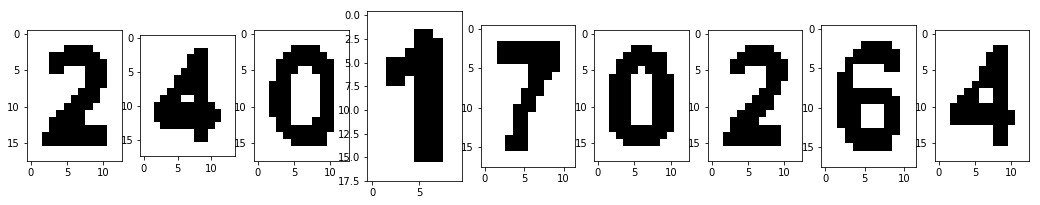

In [92]:
plotDigits(getImageDigits("./test-images/rut_2.png"))

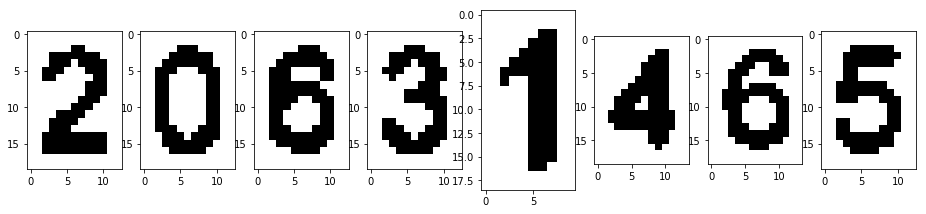

In [93]:
plotDigits(getImageDigits("./test-images/rut_3.png"))

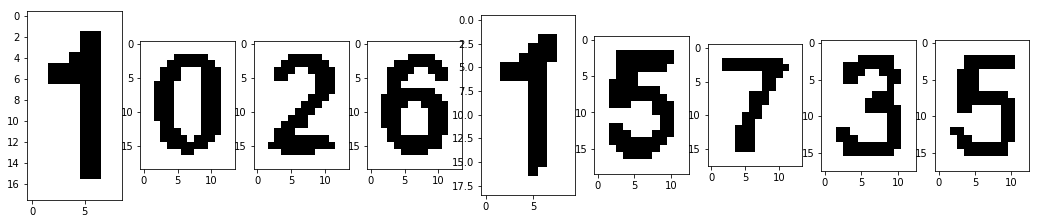

In [94]:
plotDigits(getImageDigits("./test-images/rut_4.png"))

# Inspect Training Set

Ahora se trabajará con los dígitos de pruebas. Se realiará un análisis exploratorio para posteriomente procesar las imágenes.

In [37]:
sampleCeroFilename = "./digits/0/dig_0_100.png"
sampleCero=io.imread(sampleCeroFilename)

In [144]:
sampleCero

array([[255, 255, 255,   0, 255, 255, 255, 255, 255, 255,   0, 255, 255],
       [255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255,   0,   0,   0,   0, 255, 255, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0],
       [255,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0],
       [255,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255, 

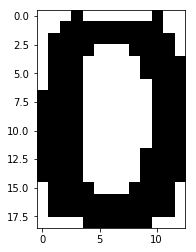

In [38]:
plt.imshow(sampleCero,cmap='gray')
plt.show()

## Gradientes: Prewitt, Sobel y Manual

In [172]:
prewittH = filters.prewitt_h(sampleCero)
prewittV = filters.prewitt_v(sampleCero)
sobelH = filters.sobel_h(sampleCero)
sobelV = filters.sobel_v(sampleCero)

In [177]:
maskX = [[-1, 0, 1]]
maskY = [[-1], [0], [1]]
gradX = signal.convolve(sampleCero, maskX, mode = 'same')
gradY = signal.convolve(sampleCero, maskY, mode = 'same')

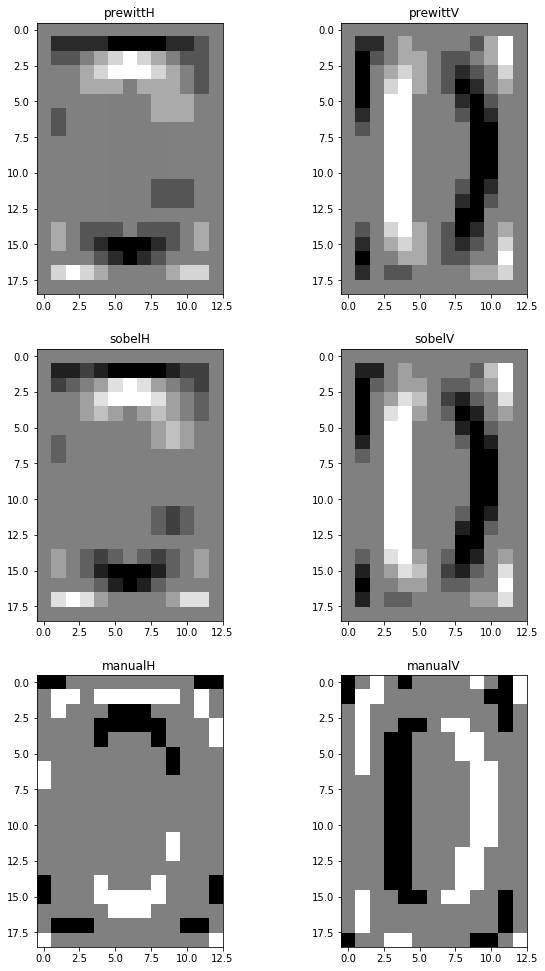

In [178]:
fig = plt.figure(figsize=(10,17))

ax = plt.subplot(3, 2, 1)
ax.set_title("prewittH")
ax.imshow(prewittH, cmap="gray")

ax = plt.subplot(3, 2, 2)
ax.set_title("prewittV")
ax.imshow(prewittV, cmap="gray")

ax = plt.subplot(3,2, 3)
ax.set_title("sobelH")
ax.imshow(sobelH, cmap="gray")

ax = plt.subplot(3, 2, 4)
ax.set_title("sobelV")
ax.imshow(sobelV, cmap="gray")

ax = plt.subplot(3, 2, 5)
ax.set_title("manualH")
ax.imshow(gradY, cmap="gray")

ax = plt.subplot(3, 2, 6)
ax.set_title("manualV")
ax.imshow(gradX, cmap="gray")

plt.show()

## Magnitudes y Orientaciones
Se calculan las magnitudes y orientaciones para los gradientes antes encontrados.

In [199]:
orientPrewitt = np.arctan2(prewittV, prewittH) 
orientSobel = np.arctan2(sobelV, sobelH)
orientManual = np.arctan2(gradY, gradX)

magPrewitt = np.sqrt(prewittV**2 + prewittH**2)
magSobel = np.sqrt(sobelV**2 + sobelH**2)
magManual = np.sqrt(gradY**2 + gradX**2)

In [200]:
print("max mag:", np.max(magManual))
print("max orn:", np.max(orientManual))
print("min mag:", np.min(magManual))
print("min orn:", np.min(orientManual))

max mag: 360.624458405
max orn: 2.35619449019
min mag: 0.0
min orn: 0.0


## Histograma de Orientaciones: Implementación Numpy
Este método solo contempla las orientaciones y no la magnitud. Tampoco contempla  el Hard y Soft Assignment, por lo que se descartará posteriormente, para ser implementado de forma manual.

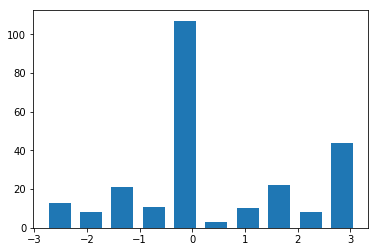

In [106]:
hist, bins = np.histogram(orientPrewitt, bins=10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Histograma de Orientaciones: Manual

In [277]:
def histogram(image, kBins):
    hist = np.zeros(kBins, dtype=np.float32)
    m, n = image.shape
    
    gradX = signal.convolve(image, maskX, mode = 'same')
    gradY = signal.convolve(image, maskY, mode = 'same')
    orientManual = (np.arctan2(gradY, gradX)  * 180 / np.pi) %360
    magManual = np.sqrt(gradY**2 + gradX**2)
    
    maxVal = np.max(magManual) * np.max(orientManual)
    
    for i in range(m):
        for j in range(n):
            # Skip those with magnitude 0.
            if(magManual[i,j] != 0):
                calc = (orientManual[i,j] * magManual[i,j])
                kbin = int(round(calc/maxVal*(kBins-1)))
                hist[kbin] += 1.0
    return hist

In [278]:
def plotHist(histogram, kBins):
    plt.bar(np.arange(kBins), histogram)
    plt.show()

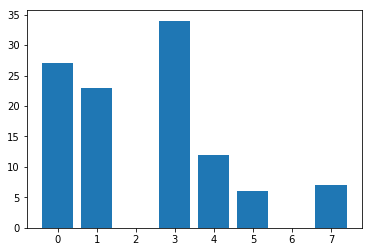

In [279]:
plotHist(histogram(sampleCero,8),8)

## Refactor para cálculo de histograma

In [111]:
def getImageOrientations(testImageFilename):
    sampleImage=io.imread(testImageFilename)
    prewittH = filters.prewitt_h(sampleImage)
    prewittV = filters.prewitt_v(sampleImage)
    orientPrewitt = np.arctan2(prewittV, prewittH)
    return orientPrewitt

In [112]:
def getOrientationHistogram(imageOrientations, binCount):
    return np.histogram(imageOrientations, bins=binCount)

In [113]:
def plotOrientationsHistogram(imageOrientations, binCount):
    hist, bins = getOrientationHistogram(imageOrientations, binCount)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

## Test on different numbers

In [122]:
sampleDigitFilenameList =["./digits/0/dig_1500070685.png",
                    "./digits/1/dig_1500063963.png",
                    "./digits/2/dig_1500063977.png",
                    "./digits/3/dig_1500063964.png",
                    "./digits/4/dig_1500063982.png",
                    "./digits/5/dig_1500064000.png",
                    "./digits/6/dig_1500063975.png",
                    "./digits/7/dig_1500064329.png",
                    "./digits/8/dig_1500064008.png",
                    "./digits/9/dig_1500063965.png",
                    "./digits/K/dig_1500066216.png"
                   ]

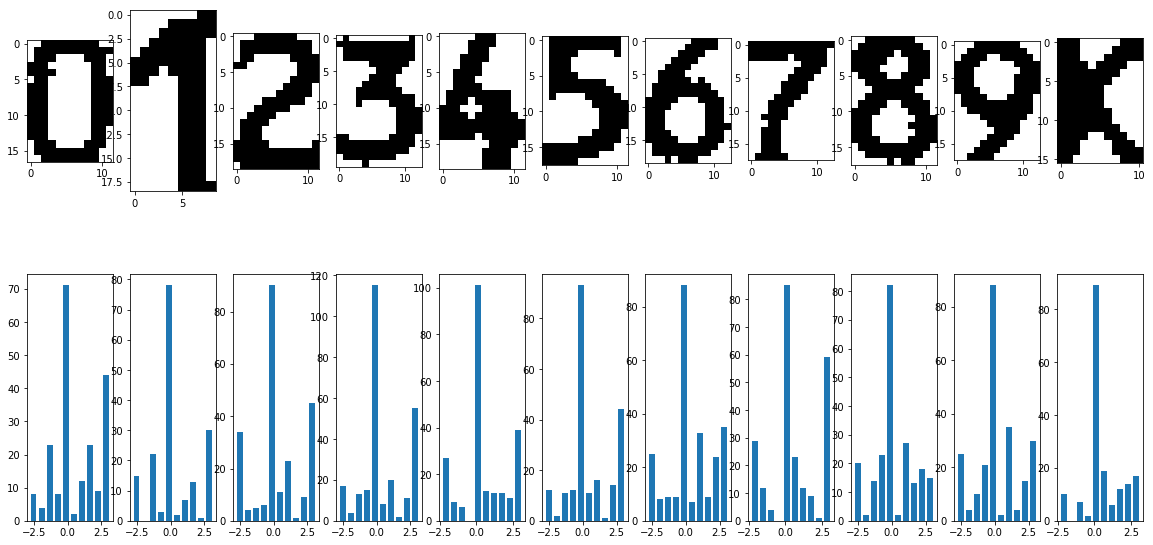

In [129]:
plt.figure(figsize=(20,10))
columns = len(sampleDigitFilenameList)
i=1
for sampleDigitFilename in sampleDigitFilenameList:
    sampleDigit=io.imread(sampleDigitFilename)
    plt.subplot(2, columns, i)
    plt.imshow(sampleDigit, cmap="gray")
    plt.subplot(2, columns, columns+i)
    hist, bins = getOrientationHistogram(getImageOrientations(sampleDigitFilename), 10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    i = i+1

In [ ]:

i = 0
for digit in digits:
    plt.subplot(len(digits) / columns + 1, columns, i+1)
    plt.imshow(digit, cmap="gray")
    i = i + 1

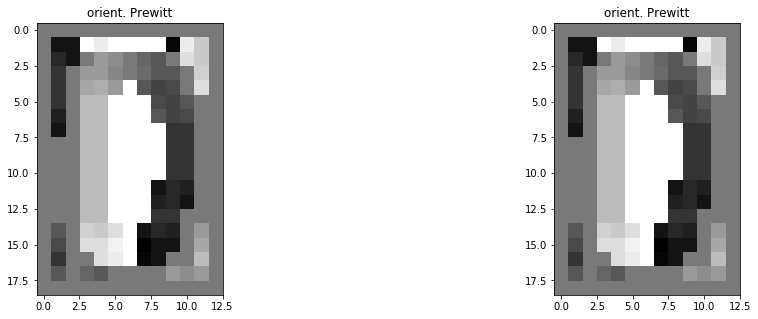

In [64]:
fig = plt.figure(figsize=(17,5))

ax = plt.subplot(1, 2, 1)
ax.set_title("orient. Prewitt")
plt.imshow(orientPrewitt, cmap="gray")

ax = plt.subplot(1, 2, 2)
ax.set_title("orient. Prewitt")
plt.imshow(orientPrewitt, cmap="gray")

plt.show()

In [227]:
from skimage.feature import hog
from skimage import data, color, exposure

In [ ]:
sampleCeroFilename = "./digits/0/dig_0_100.png"
image=io.imread(sampleCeroFilename)

In [230]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

TypeError: hog() got an unexpected keyword argument 'visualize'

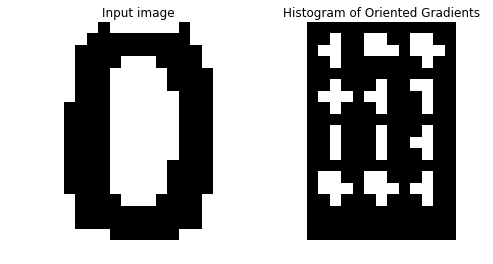

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()